# Single source shortest path with MRJob on Hadoop

## Shortest path graph distances (unit test)


In [1]:
%%writefile directed_toy_graph.txt
1	{'2': 1, '6': 1}
2	{'1': 1, '3': 1, '4': 1}
3	{'2': 1, '4': 1}
4	{'2': 1, '5': 1}
5	{'1': 1, '2': 1, '4': 1}

Writing directed_toy_graph.txt


In [2]:
%%writefile undirected_toy_graph.txt
1	{'2': 1,'5': 1}
2	{'1': 1,'3': 1,'4': 1,'5': 1}
3	{'2': 1, '4': 1}
4	{'2': 1,'3': 1,'5': 1}
5	{'1': 1, '2': 1, '4': 1}

Writing undirected_toy_graph.txt


In [3]:
%%writefile undirected_weighted_toy_graph.txt
1	{"2": 1, "5": 100}
2	{"1": 1, "3": 1, "5": 1, "4": 1}
3	{"2": 1, "4": 1}
4	{"3": 1, "2": 1, "5": 1}
5	{"1": 100, "2": 1, "4": 1, "6":1}
6	{"5": 1, "7": 1}
7	{"6": 1}

Writing undirected_weighted_toy_graph.txt


In [4]:
!cat directed_toy_graph.txt
print "\n","-"*100
!cat undirected_toy_graph.txt
print "\n","-"*100
!cat undirected_weighted_toy_graph.txt

1	{'2': 1, '6': 1}
2	{'1': 1, '3': 1, '4': 1}
3	{'2': 1, '4': 1}
4	{'2': 1, '5': 1}
5	{'1': 1, '2': 1, '4': 1}
----------------------------------------------------------------------------------------------------
1	{'2': 1,'5': 1}
2	{'1': 1,'3': 1,'4': 1,'5': 1}
3	{'2': 1, '4': 1}
4	{'2': 1,'3': 1,'5': 1}
5	{'1': 1, '2': 1, '4': 1}
----------------------------------------------------------------------------------------------------
1	{"2": 1, "5": 100}
2	{"1": 1, "3": 1, "5": 1, "4": 1}
3	{"2": 1, "4": 1}
4	{"3": 1, "2": 1, "5": 1}
5	{"1": 100, "2": 1, "4": 1, "6":1}
6	{"5": 1, "7": 1}
7	{"6": 1}

<img src="http://www.candpgeneration.com/images/graphs.png" style="float:left;"/>

In [45]:
%%writefile sssp.py

from mrjob.job import MRJob # use: define mrjob jobs
from mrjob.step import MRStep # use: define steps in mrjob
import sys    # use:  prints out maximum integer available at the system
import ast    # use: evaluate string literals
import os     # use: helps reading in command line arguments
import json   # use: load iterations
import re
import numpy as np # use:

def choose_job(job_type):
    '''Helps calling the correct job type that matches the command line argument'''

    if job_type == 'initialize':
        return 'MRShortestPathInitializer'
    
    elif job_type == 'expand':
        return 'MRShortestPathExpander'
    else:
        raise ValueError("Choose 'initialize' or 'expand'.")

class MRShortestPath(MRJob):


    def configure_options(self):
        super(MRShortestPath, self).configure_options()
        self.add_passthrough_option('--source_node', default ='1')

    def remove_empty_list(self, l):
        return   [x for x in l if x]

    def flatten(self,l):
         # flatten the remaining list
        return self.flatten(l[0]) + (self.flatten(l[1:]) if len(l) > 1 else []) if type(l) is list else [l]


    # ------------------------------- MRSteps -------------------------- #
    def prepare_graph(self, _, line):
        '''Prepares a graph by setting a source node and default values'''

        key, value = line.split('\t')
        neighbors = ast.literal_eval(value)
        if key == self.options.source_node:
            yield key, (neighbors, 0, 'Q',[key])
        else:
            yield key, (neighbors, sys.maxint, 'U',[])

    def expand_frontier(self, _, value):
        '''Expands the frontier by adding neighbors to the queue'''

        values = json.loads(value)
        key, value = values
        neighbors, dist, type, path = value
        path = self.remove_empty_list(path)
        if type == 'Q':
            # change type to visited
            type = 'V'
            # and place neighbors in the queue
            for neighbor, neighbor_dist in neighbors.items():
                temp_path = tuple(path)
                temp_path = temp_path + (neighbor,)
                yield neighbor, (None, dist + neighbor_dist, 'Q', temp_path)
#                yield neighbor, (None, dist + neighbor_dist, 'Q', temp_path)
        yield key, (neighbors, dist, type, path)



    def merge_paths(self, key, values):
        '''Merges parths in the queue'''
        
        neighbors, dists, types, paths = {}, (), (), ()
        # exhaust the values
        for value in values:
            # rewrite None as NA because later we will update the dictionary and Nones cannot be keys
            if value[0] is None:
                value[0] = {"NA":"NA"}
            neighbors.update(value[0])
            dists = dists + (value[1],)
            types = types + (value[2],)
            paths = paths + (value[3],)
        # if there is only one element in the stream, it is either visited or unvisited,
        #  and requires no action
        if len(types) == 1:
            yield key, (neighbors, dists, types, paths)
        # if there is more than one, merge them
        else:
            # merge the lines in the queue by removing the nulls ('NA')
            neighbors = {neighbor:distance for (neighbor,distance) in neighbors.items() if neighbor is not 'NA'}
            # rewrite the distance to the minimal distance
            dist = min(dists)
            # if any of the nodes in the queue are already visited, set it to visited
            type = 'V' if any(type == 'V' for type in types) else 'Q'
            yield key, (neighbors, dist, type, paths)



class MRShortestPathInitializer(MRShortestPath):

    def configure_options(self):
        # inherit configurations from parent class
        super(MRShortestPathInitializer, self).configure_options()

    def steps(self):
        return [
            MRStep(
                mapper = self.prepare_graph
            )
        ]

class MRShortestPathExpander(MRShortestPath):

    def configure_options(self):
        # inherit configurations from parent class
        super(MRShortestPathExpander, self).configure_options()

    def steps(self):
        return [
            MRStep(
                mapper = self.expand_frontier,
                reducer = self.merge_paths
            )
        ]



if __name__ == '__main__':
    job_type = os.environ.get('JOB_TYPE','expand')
    eval(choose_job(job_type)).run()


Overwriting sssp.py


In [72]:
%%writefile sssp_driver.py
from sssp import MRShortestPath, MRShortestPathInitializer, MRShortestPathExpander
import json
import sys
import re

filename = sys.argv[1]
source_node = sys.argv[2]
end_node = sys.argv[3]


# ---------------------------------- initialize graph -------------------------------- #
mrJob_init = MRShortestPathInitializer(args=[filename,'--source_node',source_node])
with mrJob_init.make_runner() as runner:
    runner.run()

    with open('graph_input.txt', 'w') as outfile:
        for line in runner.stream_output():
            out = mrJob_init.parse_output_line(line)
            json.dump(out, outfile)
            outfile.write('\n')

# --------------------------------- update graph ---------------------------------- #

mrJob_update = MRShortestPathExpander(args=['graph_input.txt'])

Q_re = re.compile(r'Q')
V_re = re.compile(r'V')
empty_queue = False
iteration_counter = 0
while empty_queue == False:
#while iteration_counter < 0:

    print 'iteration: ', iteration_counter

    with mrJob_update.make_runner() as runner:
        runner.run()

        queue_length = 0

        with open('graph_input.txt', 'w') as outfile:
            for line in runner.stream_output():
                out = mrJob_init.parse_output_line(line)
                json.dump(out, outfile)
                outfile.write('\n')
                if Q_re.search(str(out[1][2])):
                    queue_length += 1

                # extract paths leading to the end node
                if out[0] == end_node and V_re.search(str(out[1][2])):
                    paths = out[1][3]



        # stopping criterion
        if queue_length == 0:
            empty_queue = True
            print 'ready!'

        iteration_counter += 1

# ----------------------------- extract paths --------------------------- #
NUM_RE = re.compile(r'[0-9]+')
path_lengths = {}
shortest_distance = sys.maxint
for path in re.split('(\]\s*, \s*\[)', str(paths)):
    p = NUM_RE.findall(path)
    if len(p) > 0:
        path_lengths.setdefault(len(p), []).append(p)
        shortest_distance = min(len(p),shortest_distance)


# # ---------------------------- return shortest path(s) ---------------- #

print '\nThe shortest distance is {dist}.\n The path(s) is (are): {path}'.format(
    dist=shortest_distance-1, path=path_lengths[shortest_distance])

Overwriting sssp_driver.py


In [73]:
!python sssp_driver.py undirected_toy_graph.txt 1 4 

iteration:  0
iteration:  1
iteration:  2
ready!

The shortest distance is 2.
 The path(s) is (are): [['1', '2', '4'], ['1', '5', '4']]


In [11]:
!python sssp_driver.py directed_toy_graph.txt 1 5

iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
ready!

The shortest distance is 3.
 The path(s) is (are): [['1', '2', '4', '5']]


##  Exploratory data analysis (NLTK synonyms - systems test)</h1>


In [74]:
%%writefile MRFrequencyDistribution.py

from mrjob.job import MRJob
from mrjob.step import MRStep
import ast

class MRFrequencyDistribution(MRJob):

    SORT_VALUES = True
    
    def configure_options(self):
        super(MRFrequencyDistribution, self).configure_options()
        self.add_passthrough_option('--n_mappers', default='2')
        self.add_passthrough_option('--n_reducers', default='1')
        

    def steps(self):
        return [
            MRStep(
                mapper = self.mapper,
                reducer_init = self.reducer_init,
                reducer = self.reducer,
                reducer_final = self.reducer_final,
                jobconf ={
                     'mapred.output.key.comparator.class':'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                     'mapred.text.key.comparator.options': '-k2n',
                     'mapreduce.job.maps':'{0}'.format(self.options.n_mappers),
                     'mapreduce.job.reduces':'{0}'.format(self.options.n_reducers)
                     }
            )

        ]

    def mapper(self, _, line):
        key, value = line.split('\t')
        synonyms = ast.literal_eval(value)
        yield int(key), len(synonyms)

    def reducer_init(self):
        self.n = 0
        self.total_link = 0

    def reducer(self, key, values):
        for value in values:
            self.n += 1
            self.total_link += value
            yield key, int(value)

    def reducer_final(self):
        yield 'N', (self.n)
        yield 'Total', self.total_link


if __name__ == "__main__":
    MRFrequencyDistribution.run()

Overwriting MRFrequencyDistribution.py


In [3]:
from MRFrequencyDistribution import MRFrequencyDistribution
import json

mrJob = MRFrequencyDistribution(args=['synNet.txt','-r','local','q'])

with mrJob.make_runner() as runner:
    runner.run()
    
    N = []
    Total = []
    num_links = []
    with open('res.txt', 'w') as outfile:
        for line in runner.stream_output():
            out = mrJob.parse_output_line(line)
            json.dump(out, outfile)
            if out[0] == 'N':
                N.append(out[1])
            elif out[0] == 'Total':
                Total.append(out[1])
            else:
                num_links.append(out[1])
            outfile.write('\n')

            
# --------------------------- calculate statistics ------------------------ #            
N = sum(N)
TOTAL = sum(Total)
            
print 'Number of nodes: {0}\n'.format(N)
print 'Average number of links per node: {0}'.format(float(TOTAL)/N)


Number of nodes: 8271

Average number of links per node: 7.39136742836


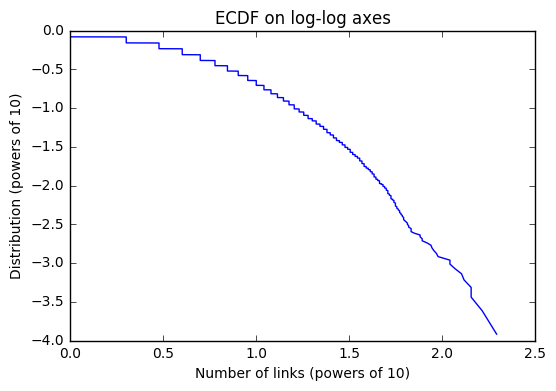

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

sorted_num_links = np.sort(num_links)
yvals = 1-np.arange(len(sorted_num_links))/float(len(sorted_num_links))
plt.plot(np.log10(sorted_num_links), np.log10(yvals))
plt.title('ECDF on log-log axes')
plt.xlabel('Number of links (powers of 10)')
plt.ylabel('Distribution (powers of 10)')


For some reason, the network literature uses the survival function but calls it the cumulative distribution function to investigate the power law properties of networks. A linear log-log ECDF plot would imply a (random) power law network. This curved power law rather resembles cumulative distribution function of scale-free networks. 

<h1 style="color:#021353;"> Shortest path graph distances (NLTK synonyms)</h1>



In [9]:
%%writefile MRShortestPathInitializer.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawProtocol
import ast
import sys


class MRShortestPathInitializer(MRJob):
    OUTPUT_PROTOCOL = RawProtocol

    def configure_options(self):
        super(MRShortestPathInitializer, self).configure_options()
        self.add_passthrough_option('--source_node', default='1')
        self.add_passthrough_option('--n_mappers', default='2')
        
    def steps(self):
        return [
            MRStep(
                mapper = self.mapper,
                jobconf ={
                     'mapreduce.job.maps':'{0}'.format(self.options.n_mappers),
                     }
            )  
        ]

    # ------------------------------- MRSteps -------------------------- #
    def mapper(self, _, line):
        '''Prepares a graph by setting a source node and default values'''

        key, value = line.split('\t')
        neighbors = ast.literal_eval(value)
        if key == self.options.source_node:
            yield key, str(neighbors) + ";" + "0" + ";" + 'Q' + ";" + str([key])
        else:
            yield key, str(neighbors) + ";" + str(sys.maxint) + ";" + 'U' + ";" + str([])



if __name__ == '__main__':
    MRShortestPathInitializer.run()


Overwriting MRShortestPathInitializer.py


In [28]:
%%writefile MRShortestPathExpander.py
from mrjob.job import MRJob  # use: define mrjob jobs
from mrjob.step import MRStep  # use: define steps in mrjob
from mrjob.protocol import RawProtocol
import sys  # use:  prints out maximum integer available at the system
import ast  # use: evaluate string literals
import os  # use: helps reading in command line arguments
import json  # use: load iterations
import re
import numpy as np  # use:


class MRShortestPathExpander(MRJob):

    OUTPUT_PROTOCOL = RawProtocol
    TYPE_RE = re.compile(r'[A-Z]')
    NUM_RE = re.compile(r'[0-9]+')
    Q_RE = re.compile(r'Q')

    def configure_options(self):
        super(MRShortestPathExpander, self).configure_options()
        self.add_passthrough_option('--source_node', default='1')
        self.add_passthrough_option('--n_mappers', default='2')
        self.add_passthrough_option('--n_reducers', default='1')

    def remove_empty_list(self, l):
        return [x for x in l if x]

    def flatten(self, l):
        # flatten the remaining list
        return self.flatten(l[0]) + (self.flatten(l[1:]) if len(l) > 1 else []) if type(l) is list else [l]
    
    def steps(self):
        return [
            MRStep(
                mapper = self.expand_frontier,
                reducer = self.merge_paths,
                jobconf ={
                     'mapreduce.job.maps':'{0}'.format(self.options.n_mappers),
                     'mapreduce.job.reduces':'{0}'.format(self.options.n_reducers)
                     }
            )  
        ]


    # ------------------------------- MRSteps -------------------------- #

    def expand_frontier(self, _, line):
        '''Expands the frontier by adding neighbors to the queue'''

        #        values = json.loads(value)
        key, value = line.replace('\"', '').split('\t')
        neighbors, dist, node_type, path = value.split(";")
        neighbors = ast.literal_eval(neighbors)
        path = ast.literal_eval(path)
        dist = ast.literal_eval(dist)
        if self.Q_RE.search(str(node_type)):
            # change type to visited
            node_type = 'V'
            # and place neighbors in the queue
            for neighbor, neighbor_dist in neighbors.items():
                temp_path = tuple(path)
                temp_path = temp_path + (neighbor,)
                try:
                    yield neighbor, ("NA", int(dist)+neighbor_dist, 'Q', temp_path)
#                    yield neighbor, "{'NA':0}" + ";" + str(int(dist) + neighbor_dist) + ";" + 'Q' + ";" + str(temp_path)
                except TypeError:
#                    yield neighbor, "{'NA':0}" + ";" + str(dist[0] + neighbor_dist) + ";" + 'Q' + ";" + str(temp_path)
                   yield neighbor, ("NA", int(dist[0]) + neighbor_dist, 'Q', temp_path)
#                yield neighbor, (None, int(dist) + neighbor_dist, 'Q', temp_path)
#        yield key, str(neighbors) + ";" + str(dist) + ";" + str(node_type) + ";" + str(path)
        yield key, (neighbors, dist, node_type, path)




    def merge_paths(self, key, values):
        '''Merges parths in the queue'''


        neighbors, dists, types, paths = {}, [], [], []
        # exhaust the values
        for value in values:

            # rewrite None as NA because later we will update the dictionary and Nones cannot be keys
            if value[0] == 'NA':
                value[0] = {"NA": 0}
            neighbors.update(value[0])
            dists .append(value[1])
            types.append(value[2])
            paths.append(value[3])
        # if there is only one element in the stream, it is either visited or unvisited,
        #  and requires no action
        if len(types) == 1:
            yield key, str(neighbors) + ';' + str(dists) + ';' + str(types) + ";"  + str(paths)
        # if there is more than one, merge them
        else:
            # merge the lines in the queue by removing the nulls ('NA')
            #neighbors = {neighbor: distance for (neighbor, distance) in neighbors.items() if neighbor is not 'NA'}
            neighbors = dict((neighbor,distance) for (neighbor,distance) in neighbors.items() if neighbor is not 'NA')
            # rewrite the distance to the minimal distance
            dist = min(dists)
            # if any of the nodes in the queue are already visited, set it to visited
            type = 'V' if any(type == 'V' for type in self.TYPE_RE.findall(str(types))) else 'Q'
            paths = self.remove_empty_list(paths)
            if key != "NA":
                yield key, str(neighbors) + ";" + str(dist) + ';' + str(type) + ";"+ str(paths)



if __name__ == '__main__':
    MRShortestPathExpander.run()


Overwriting MRShortestPathExpander.py


In [98]:
%%writefile MRShortestPathFinder.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import re
import ast

class MRShortestPathFinder(MRJob):
    '''Calculates the shortest distance between source and target node.

    Options:
    --------
    Target node, set with the --target_node switch when calling the function

    Returns:
    target node, (shortest distance, all paths that have the shortest distance)
    '''



    def configure_options(self):
        super(MRShortestPathFinder, self).configure_options()
        self.add_passthrough_option('--target_node', default='1')
        self.add_passthrough_option('--n_mappers', default='2')
        
    def steps(self):
        return [
            MRStep(
                mapper_init = self.mapper_init,
                mapper = self.mapper,
                jobconf ={
                     'mapreduce.job.maps':'{0}'.format(self.options.n_mappers),
                     }
            )  
        ]


    def mapper_init(self):
        self.NUM_RE = re.compile(r'[0-9]+')
        self.path_lengths = {}
        self.shortest_distance = sys.maxint

    def mapper(self, _, line):
        key, value = line.replace('\"', '').split('\t')
        #       yield key, value
        if key == self.options.target_node:
            neighbors, dist, node_type, paths = value.split(";")
            try:
                self.shortest_distance = int(dist)
            except ValueError:
                self.shortest_distance = int(ast.literal_eval(dist)[0])

            for path in re.split('(\]\s*, \s*\[)', str(paths)):
                p = self.NUM_RE.findall(path)
                if len(p) == self.shortest_distance+1 and any(node == self.options.target_node for node in p):
                    self.path_lengths.setdefault(len(p), []).append(p)
                    yield key, (self.shortest_distance, p)



if __name__ == "__main__":
    MRShortestPathFinder.run()

Overwriting MRShortestPathFinder.py


In [45]:
%%writefile MRVisitChecker.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import re

class MRVisitChecker(MRJob):
    '''Checks whether the target node is visited.

    Returns:
    --------
    As many rows as mappers, each row is (null, True or False), if True, there are no nodes left in the queue.
    If all mappers return True, the network (all connected components to the source node) is explored.
    '''

    def configure_options(self):
        super(MRVisitChecker, self).configure_options()
        self.add_passthrough_option('--target_node', default='1')
        self.add_passthrough_option('--n_mappers', default='2')
        
    def steps(self):
        return [
            MRStep(
                mapper = self.mapper,
                mapper_final = self.mapper_final,
                jobconf ={
                     'mapreduce.job.maps':'{0}'.format(self.options.n_mappers),
                     }
            )  
        ]



    TYPE_RE = re.compile(r'[A-Z]')
    V_RE = re.compile(r'V')
    # every mapper that has a node in the queue (Q) will set COMPLETE to False
    VISITED = False

    def mapper(self, key, line):
        key, value = line.replace('\"', '').split('\t')
        #       yield key, value
        if key == self.options.target_node:
            neighbors, dist, node_type, paths = value.split(";")
            node_type = self.TYPE_RE.findall(str(node_type))[0]
            if self.V_RE.search(str(node_type)):
                self.VISITED = True

    def mapper_final(self):
        yield None, str(self.VISITED)

if __name__ == "__main__":
    MRVisitChecker.run()



Overwriting MRVisitChecker.py


In [46]:
!hadoop fs -mkdir /tmp/alenart_hdfs/sn72

mkdir: `/tmp/alenart_hdfs/sn72': File exists


In [95]:
%%writefile shortest_path_driver.sh
#!/bin/bash

HDFS_FOLDER=/tmp/alenart_hdfs/sn72
DATA=synNet.txt
PYTHON_BIN=/opt/anaconda2/bin/python2.7
VISITED=0
SOURCE_NODE=7827
TARGET_NODE=536
i=1

hadoop fs -rm -r $HDFS_FOLDER/new

echo "Initializing the graph."
$PYTHON_BIN MRShortestPathInitializer.py $DATA -r hadoop --no-output --output-dir $HDFS_FOLDER/new \
        --source_node $SOURCE_NODE -q


while (($VISITED == 0))
   do
      echo "iteration $i"
      ((i = i + 1))
      echo "Clean up."
      hadoop fs -rm -r $HDFS_FOLDER/visit
      hadoop fs -rm -r $HDFS_FOLDER/old
      hadoop fs -mv $HDFS_FOLDER/new $HDFS_FOLDER/old
      echo "Expand frontier."
      $PYTHON_BIN MRShortestPathExpander.py hdfs://$HDFS_FOLDER/old/* -r hadoop --no-output \
       --output-dir $HDFS_FOLDER/new -q
      echo "Checking whether node $TARGET_NODE is visited..."
      $PYTHON_BIN MRVisitChecker.py hdfs://$HDFS_FOLDER/new/* -r hadoop --no-output --output-dir $HDFS_FOLDER/visit \
       --target_node $TARGET_NODE -q
      VISITED=$(hadoop fs -cat $HDFS_FOLDER/visit/* | grep 'True' | wc -l)
      if [ $VISITED -eq 0 ]; then
          echo "Not yet."
      fi
done

echo "$TARGET_NODE is visited."

echo "Clean up."
hadoop fs -rm -r $HDFS_FOLDER/result
echo "Returning shortest path(s):"
$PYTHON_BIN MRShortestPathFinder.py hdfs://$HDFS_FOLDER/new/* -r hadoop --target_node $TARGET_NODE --no-output \
     --output-dir $HDFS_FOLDER/result -q
hadoop fs -cat $HDFS_FOLDER/result/*

Overwriting shortest_path_driver.sh


In [99]:
!bash shortest_path_driver.sh

17/03/14 16:32:06 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/tmp/alenart_hdfs/sn72/new' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/alenart/.Trash/Current
Initializing the graph.
iteration 1
Clean up.
17/03/14 16:32:46 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/tmp/alenart_hdfs/sn72/visit' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/alenart/.Trash/Current
17/03/14 16:32:49 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/tmp/alenart_hdfs/sn72/old' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/alenart/.Trash/Current
Expand frontier.
Checking whether node 536 is visited...
Not yet.
iteration 2
Clea

In [104]:
!hadoop fs -cat /tmp/alenart_hdfs/sn72/result/* > result72.txt

In [139]:
import ast

indexdict = {}
with open('result72.txt','r') as infile, open('indices.txt','r') as indices:
    for row in indices:
        word, index = row.strip().split()
        indexdict[index] = word
    for line in infile:
        key, value = line.strip().split('\t')
        value = ast.literal_eval(str(value))
        values = [indexdict[value] for value in value[1]]
        print " >>> ".join(values)

walk >>> pass >>> draw >>> make
walk >>> pass >>> clearing >>> make
walk >>> pass >>> giving >>> make
walk >>> pass >>> drew >>> make
walk >>> passes >>> give >>> make
walk >>> pass >>> drawings >>> make
walk >>> pass >>> draws >>> make
walk >>> passes >>> reach >>> make
walk >>> pass >>> given >>> make
walk >>> passes >>> clear >>> make
walk >>> pass >>> drawn >>> make
walk >>> pass >>> gives >>> make
walk >>> pass >>> Give >>> make


<h1 style="color:#021353;">Exploratory data analysis (Wikipedia)</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">

</pre>
</div>

In [2]:

!hadoop fs -rm -r /tmp/alenart_hdfs/eda73
!python MRFrequencyDistribution.py hdfs:///tmp/hw7/wiki_out.txt -r hadoop -q\
    --no-output --output-dir /tmp/alenart_hdfs/eda73 --n_mappers 150 --n_reducers 15


/bin/sh: 1: hadoop: not found
python: can't open file 'MRFrequencyDistribution.py': [Errno 2] No such file or directory


In [21]:
!hadoop fs -cat /tmp/alenart_hdfs/eda73/* | grep 'Total' > totals.txt
!hadoop fs -cat /tmp/alenart_hdfs/eda73/* | grep 'N' > Ns.txt

In [27]:
total = 0
n = 0
with open('totals.txt','r') as totalfile, open('Ns.txt','r') as nfile:
    for tline,nline in zip(totalfile,nfile):
        _,tot = tline.split()
        _,ns = nline.split()
        total += int(tot)
        n += int(ns)
print 'Number of links (total): {0}'.format(total)
print 'Number of nodes: {0}'.format(n)
print 'Average number of links per node: {0}'.format(float(total)/n)

Number of links (total): 142114057
Number of nodes: 5781290
Average number of links per node: 24.5817208616


In [77]:
!hadoop fs -cat /tmp/alenart_hdfs/eda73/part-00000 | tail -10

6075728	2960
7900831	2971
7912072	3074
7812370	3166
7812280	3379
7911901	4161
7768780	4817
7902703	5399
"N"	384601
"Total"	9471579


Assume that the result of any of the reducers is a random sample of the population. For the sake of convenience, instead of writing a mapreduce program that calculates the quantile function of the whole dataset, plot only the results of the first reducer.

In [78]:
!hadoop fs -cat /tmp/alenart_hdfs/eda73/part-00000 > data.txt 
!awk -F" " '{print $2}' data.txt > num_links.txt

Hadoop already returned the results sorted by the second column, hence we don't need to sort again, e.g.

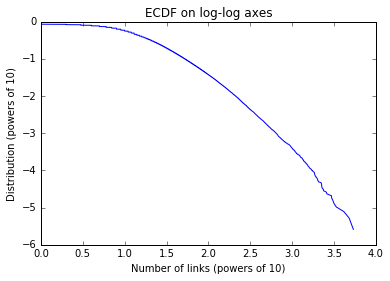

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

num_links = []
with open('num_links.txt','r') as infile:
    for line in infile:
        num_links.append(int(line.strip()))
        

num_links = list(num_links[:-2])
yvals = 1-np.arange(len(num_links))/float(len(num_links))
plt.plot(np.log10(num_links), np.log10(yvals))
plt.title('ECDF on log-log axes')
plt.xlabel('Number of links (powers of 10)')
plt.ylabel('Distribution (powers of 10)')

<h1 style="color:#021353;"> Shortest path graph distances (Wikipedia)</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">


When running your code on the Wikipedia network, proof its function by running the job:

- shortest path from "Ireland" (index=6176135) to "University of California, Berkeley" (index=13466359),

and show your code's output. Show the shortest path in terms of just page IDS but also in terms of the name of page (show of your MapReduce join skills!!)

Once your code is running, find some other shortest paths and report your results.
</pre>
</div>

In [15]:
!hadoop fs -mkdir /tmp/alenart_hdfs/sp74
!/opt/anaconda2/bin/python MRShortestPathInitializer.py $DATA -r hadoop --python-bin $PYTHON_BIN  --no-output --output-dir $HDFS_FOLDER/new 
        --source_node $SOURCE_NODE -q --n_mappers 150

In [93]:
%%writefile wiki_shortest_path_driver.sh
#!/bin/bash

HDFS_FOLDER=/tmp/alenart_hdfs/sp74
DATA=hdfs:///tmp/hw7/wiki_out.txt
PYTHON_BIN=/opt/anaconda2/bin/python2.7
VISITED=0
SOURCE_NODE=6176135
TARGET_NODE=13466359
i=1

hadoop fs -rm -r $HDFS_FOLDER/new

echo "Initializing the graph."
$PYTHON_BIN MRShortestPathInitializer.py $DATA -r hadoop --no-output --output-dir $HDFS_FOLDER/new \
    --source_node $SOURCE_NODE --n_mappers 150 -q


while (($VISITED == 0))
   do
      echo "iteration $i"
      ((i = i + 1))
      echo "Clean up."
      hadoop fs -rm -r $HDFS_FOLDER/visit
      hadoop fs -rm -r $HDFS_FOLDER/old
      hadoop fs -mv $HDFS_FOLDER/new $HDFS_FOLDER/old
      echo "Expand frontier."
      $PYTHON_BIN MRShortestPathExpander.py hdfs://$HDFS_FOLDER/old/* -r hadoop --no-output \
       --output-dir $HDFS_FOLDER/new --n_mappers 150 --n_reducers 15  -q 
      echo "Checking whether node $TARGET_NODE is visited..."
      $PYTHON_BIN MRVisitChecker.py hdfs://$HDFS_FOLDER/new/* -r hadoop --no-output --output-dir $HDFS_FOLDER/visit \
       --target_node $TARGET_NODE --n_mappers 100 -q
      VISITED=$(hadoop fs -cat $HDFS_FOLDER/visit/* | grep 'True' | wc -l)
      if [ $VISITED -eq 0 ]; then
          echo "Not yet."
      fi
done

echo "$TARGET_NODE is visited."

echo "Clean up."
hadoop fs -rm -r $HDFS_FOLDER/result
echo "Returning shortest path(s):"
$PYTHON_BIN MRShortestPathFinder.py hdfs://$HDFS_FOLDER/new/* -r hadoop --target_node $TARGET_NODE --no-output \
     --output-dir $HDFS_FOLDER/result --n_mappers 100 -q
hadoop fs -cat $HDFS_FOLDER/result/*

Overwriting wiki_shortest_path_driver.sh


In [94]:
!bash wiki_shortest_path_driver.sh

17/03/14 15:41:22 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/tmp/alenart_hdfs/sp74/new' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/alenart/.Trash/Current
Initializing the graph.
iteration 1
Clean up.
17/03/14 15:43:30 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/tmp/alenart_hdfs/sp74/visit' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/alenart/.Trash/Current
17/03/14 15:43:33 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/tmp/alenart_hdfs/sp74/old' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/alenart/.Trash/Current
Expand frontier.
Checking whether node 13466359 is visited...
Not yet.
iteration 2

In [97]:
!hadoop fs -cat /tmp/hw7/wiki_indices.txt | grep '11607791'

Seamus Heaney	11607791	793	335
